In [79]:
from torch.nn import functional as F

from PIL import Image
from glob import glob
from scipy.io import loadmat

import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data
import torchvision.transforms.functional as FF

import torch
import os

#### Load the data

In [80]:
class Crowd(data.Dataset):
    def __init__(self, root_path, trans):
        self.root_path = root_path
        self.trans = trans
        self.im_list = sorted(glob(os.path.join(self.root_path, '*.jpg')))
        self.annot_list = sorted(glob(os.path.join(self.root_path, '*.mat')))
        print('number of img: {}'.format(len(self.im_list))) 


    def __len__(self):
        return len(self.im_list)

    def __getitem__(self, item):
        img_path = self.im_list[item]
        ann_path = img_path.replace('.jpg', '_ann.mat')
        img = self.train_transform(Image.open(img_path).convert('RGB'))
        keypoints = loadmat(ann_path)['annPoints']
        img = self.trans(img)

        if len(keypoints) < 300:
            c = 0
        elif len(keypoints) < 700:
            c = 1
        elif len(keypoints) < 1200:
            c = 2
        elif len(keypoints) < 2300:
            c = 3
        else:
            c = 4

        return img, c

    def train_transform(self, img):
        img = FF.resize(img, (224,224))
        img = FF.pad(img, (8,8))
        return img

In [81]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 100
batch_size = 200
learning_rate = 0.029

transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_dataset = Crowd('data/Train/', transformation)
test_dataset = Crowd('data/Test/', transformation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

number of img: 1201
number of img: 334


#### Build the Model

In [86]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 57 * 57, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        # -> n, 3, 240, 240
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 118, 118
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 57, 57
        x = x.view(-1, 16 * 57 * 57)          # -> n, 10396800
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 5
        return x

#### Hyperparameter Tuning Using Optuna

In [ ]:
import optuna
import torch.optim as optim

n_labels = 5
classes = [i for i in range(n_labels)]
n_class_correct = [0 for i in range(n_labels)]
n_class_samples = [0 for i in range(n_labels)]

def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
              }
    
    model = LeNet5().to(device)
    
    accuracy = train_and_evaluate(params, model)

    return accuracy

def train_and_evaluate(params, model):

    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0 

    for epoch in range(num_epochs):
        for i, (images,labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #evaluating
        total_acc_val = 0
        total_loss_val = 0
        n_samples = 0

        with torch.no_grad():

            for i, (images,labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                n_samples += labels.size(0)

                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss_val += loss.item()
                
                
                acc = (outputs.argmax(dim=1) == labels).sum().item()
                total_acc_val += acc
            
            accuracy = total_acc_val/n_samples

        
    return accuracy


study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=1)

#### Training Loop

Finished Training


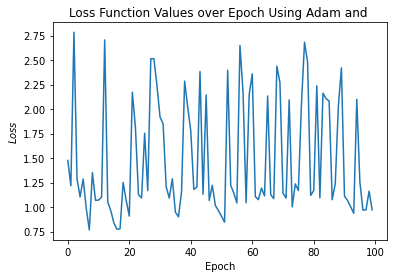

In [87]:
model = LeNet5().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

n_total_steps = len(train_loader)
running_loss = 0.0 

J_history_train = []

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    J_history_train += [loss.item()]

plt.plot(range(num_epochs), J_history_train)
plt.xlabel("Epoch")
plt.ylabel("$Loss$")
plt.title("Loss Function Values over Epoch Using Adam")

print('Finished Training')
PATH = './cnn.pth'

torch.save(model.state_dict(), PATH)

#### Testing Loop

In [88]:
# load pre-trained model
model = LeNet5()
model.load_state_dict(torch.load(PATH))
model.eval()

n_labels = 5
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    classes = [i for i in range(n_labels)]
    n_class_correct = [0 for i in range(n_labels)]
    n_class_samples = [0 for i in range(n_labels)]

    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1) # max returns (value ,index)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for j in range(labels.shape[0]):
            label = labels[j] - 1
            pred = predicted[j]

            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(n_labels):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 34.131736526946106 %
Accuracy of 0: 100.0 %
Accuracy of 1: 0.0 %
Accuracy of 2: 0.0 %
Accuracy of 3: 0.0 %
Accuracy of 4: 0.0 %
